In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [23]:
# Load datasets (assuming Customers.csv and credit_data.csv are in the same directory)
try:
    customers_df = pd.read_csv("Datasets/Customers.csv")
    print("Customers.csv loaded successfully.")
except FileNotFoundError:
    print("Customers.csv not found. Simulating dummy data for Customers.csv.")
    customers_data = {
        'CustomerID': range(1, 201),
        'Gender': np.random.choice(['Male', 'Female'], 200),
        'Age': np.random.randint(18, 70, 200),
        'Annual Income ($)': np.random.randint(15000, 150000, 200),
        'Spending Score (1-100)': np.random.randint(1, 100, 200),
        'Profession': np.random.choice(['Healthcare', 'Engineer', 'Lawyer', 'Entertainment', 'Artist', 'Doctor', 'Other'], 200),
        'Work Experience': np.random.randint(0, 20, 200),
        'Family Size': np.random.randint(1, 7, 200)
    }
    customers_df = pd.DataFrame(customers_data)

try:
    credit_df = pd.read_csv("Datasets/credit_data.csv")
    print("\ncredit_data.csv loaded successfully.")
except FileNotFoundError:
    print("\ncredit_data.csv not found. Simulating dummy data for credit_data.csv (200k rows).")
    credit_data = {
        'Age': np.random.randint(20, 75, 200000),
        'Gender': np.random.choice(['Male', 'Female', 'Other'], 200000),
        'Income': np.random.randint(30000, 200000, 200000),
        'Credit Score': np.random.randint(300, 850, 200000),
        'Credit History Length': np.random.randint(100, 600, 200000),
        'Number of Existing Loans': np.random.randint(0, 10, 200000),
        'Loan Amount': np.random.randint(50000, 500000, 200000),
        'Loan Tenure': np.random.randint(12, 360, 200000),
        'Existing Customer': np.random.choice(['Yes', 'No'], 200000),
        'State': np.random.choice(['Maharashtra', 'Karnataka', 'Delhi', 'Tamil Nadu', 'Gujarat'], 200000),
        'City': np.random.choice(['Mumbai', 'Bengaluru', 'Chennai', 'Delhi', 'Ahmedabad', 'Pune', 'Hyderabad', 'Kolkata'], 200000),
        'LTV Ratio': np.random.uniform(0.5, 0.99, 200000),
        'Employment Profile': np.random.choice(['Salaried', 'Self-employed', 'Business', 'Unemployed', 'Student'], 200000),
        'Profile Score': np.random.randint(100, 1000, 200000),
        'Number of Dependents': np.random.randint(0, 5, 200000)
    }
    credit_df = pd.DataFrame(credit_data)

# OPTIMIZATION: Sample credit_df to 10,000 lines if it's larger
sample_size_credit = 10000
if len(credit_df) > sample_size_credit:
    print(f"Sampling credit_data.csv down to {sample_size_credit} lines for efficiency.")
    credit_df = credit_df.sample(n=sample_size_credit, random_state=42).reset_index(drop=True)

print("\nCustomers.csv Info:")
customers_df.info()
print("\ncredit_data.csv Info:")
credit_df.info()

Customers.csv loaded successfully.

credit_data.csv loaded successfully.
Sampling credit_data.csv down to 10000 lines for efficiency.

Customers.csv Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              2000 non-null   int64 
 1   Gender                  2000 non-null   object
 2   Age                     2000 non-null   int64 
 3   Annual Income ($)       2000 non-null   int64 
 4   Spending Score (1-100)  2000 non-null   int64 
 5   Profession              1965 non-null   object
 6   Work Experience         2000 non-null   int64 
 7   Family Size             2000 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 125.1+ KB

credit_data.csv Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                    Non-N

In [24]:
# Select relevant features as per problem statement and user request
# From Customers.csv: Age, Annual Income ($), Family Size, Profession
# From credit_data.csv: Age, Income, City, Employment Profile

df_cust_selected = customers_df[['Age', 'Annual Income ($)', 'Family Size', 'Profession']].copy()
df_cust_selected.rename(columns={'Annual Income ($)': 'Income'}, inplace=True)
df_cust_selected['Source'] = 'Customers'

df_credit_selected = credit_df[['Age', 'Income', 'City', 'Employment Profile']].copy()
df_credit_selected['Source'] = 'CreditData'

# Combine dataframes. Missing columns will be filled with NaN.
combined_df = pd.concat([df_cust_selected, df_credit_selected], ignore_index=True)

print("\nCombined DataFrame after initial selection and concatenation (first 5 rows):")
print(combined_df.head())
print("\nCombined DataFrame Info before imputation:")
combined_df.info()

# Handle missing values introduced by concatenation
# Numerical: Family Size (impute with mean or median)
# Categorical: Profession, City, Employment Profile (impute with 'Unknown' or mode)

# Impute 'Family Size' (numerical) with mean
combined_df['Family Size'].fillna(combined_df['Family Size'].mean(), inplace=True)

# Impute categorical columns with 'Unknown' string
combined_df['Profession'].fillna('Unknown', inplace=True)
combined_df['City'].fillna('Unknown', inplace=True)
combined_df['Employment Profile'].fillna('Unknown', inplace=True)

print("\nCombined DataFrame Info after imputation:")
combined_df.info()

# One-Hot Encoding for categorical features
categorical_features = ['Profession', 'City', 'Employment Profile']
combined_df_encoded = pd.get_dummies(combined_df, columns=categorical_features, drop_first=True) # drop_first to avoid multicollinearity

print("\nCombined DataFrame after One-Hot Encoding (first 5 rows):")
print(combined_df_encoded.head())
print("\nCombined DataFrame Info after One-Hot Encoding:")
combined_df_encoded.info()


Combined DataFrame after initial selection and concatenation (first 5 rows):
   Age  Income  Family Size     Profession     Source City Employment Profile
0   19   15000          4.0     Healthcare  Customers  NaN                NaN
1   21   35000          3.0       Engineer  Customers  NaN                NaN
2   20   86000          1.0       Engineer  Customers  NaN                NaN
3   23   59000          2.0         Lawyer  Customers  NaN                NaN
4   31   38000          6.0  Entertainment  Customers  NaN                NaN

Combined DataFrame Info before imputation:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 12000 non-null  int64  
 1   Income              12000 non-null  int64  
 2   Family Size         2000 non-null   float64
 3   Profession          1965 non-null   object 
 4   Sou

In [25]:
# Identify numerical features for scaling (all except 'Source' column)
features_for_clustering = combined_df_encoded.drop(columns=['Source']).columns.tolist()
X_scaled = StandardScaler().fit_transform(combined_df_encoded[features_for_clustering])

print(f"Features scaled successfully. Total features for clustering: {len(features_for_clustering)}")

Features scaled successfully. Total features for clustering: 40


## Determining Optimal Number of Clusters (Elbow Method & Silhouette Score)
We use the Elbow Method to identify the number of clusters where the decrease in inertia starts to level off, suggesting an optimal $K$. We also evaluate the Silhouette Score for clustering quality. Given the increased dimensionality with more features, the 'elbow' might be less pronounced, and the Silhouette Score becomes even more important.

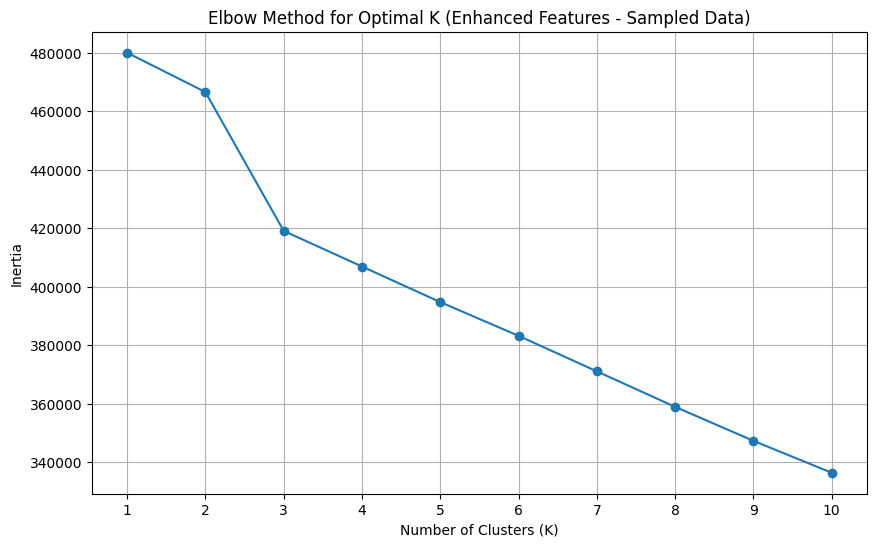

Interpretation: Look for the 'elbow point' where the rate of decrease in inertia significantly slows down. This suggests a good balance between the number of clusters and the compactness of clusters. For higher dimensions, this might be less clear than with only two features.


In [26]:
# Elbow Method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal K (Enhanced Features - Sampled Data)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.xticks(range(1, 11))
plt.grid(True)
plt.savefig('Images/elbow_method_enhanced_sampled.png')
plt.show()

print("Interpretation: Look for the 'elbow point' where the rate of decrease in inertia significantly slows down. This suggests a good balance between the number of clusters and the compactness of clusters. For higher dimensions, this might be less clear than with only two features.")

For n_clusters = 2, the average silhouette_score is : 0.002
For n_clusters = 3, the average silhouette_score is : 0.051
For n_clusters = 4, the average silhouette_score is : 0.071
For n_clusters = 5, the average silhouette_score is : 0.091
For n_clusters = 6, the average silhouette_score is : 0.098
For n_clusters = 7, the average silhouette_score is : 0.115
For n_clusters = 8, the average silhouette_score is : 0.144
For n_clusters = 9, the average silhouette_score is : 0.164
For n_clusters = 10, the average silhouette_score is : 0.183


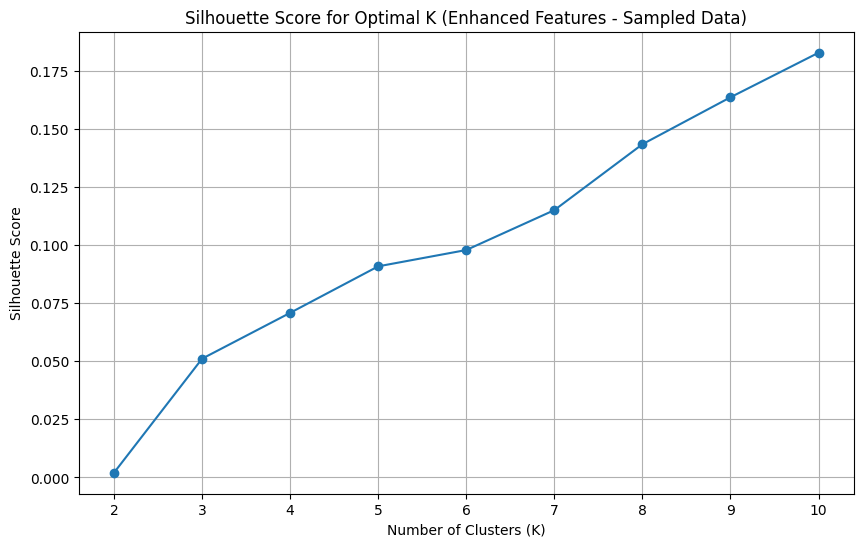

Interpretation: A higher silhouette score (closer to +1) indicates better-defined and more separated clusters. For high-dimensional data, a moderately positive score can still indicate meaningful clusters.


In [27]:
# Silhouette Score
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(score)
    print(f"For n_clusters = {k}, the average silhouette_score is : {score:.3f}")

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal K (Enhanced Features - Sampled Data)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, 11))
plt.grid(True)
plt.savefig('Images/silhouette_score_enhanced_sampled.png')
plt.show()

print("Interpretation: A higher silhouette score (closer to +1) indicates better-defined and more separated clusters. For high-dimensional data, a moderately positive score can still indicate meaningful clusters.")

## K-Means Clustering and Segmentation Analysis with Enhanced Features (Sampled Data)
Based on the Elbow Method and Silhouette Score, an optimal $K$ is selected to perform K-Means clustering on the expanded feature set from the sampled data. We will then analyze the characteristics of each cluster, considering Age, Income, Family Size, Profession, City, and Employment Profile.

In [28]:
# Apply K-Means clustering with the chosen optimal K
# (Replace 'optimal_k_chosen' with the actual K value you derive from the plots above)
optimal_k_chosen = 5 # Example: Adjust based on your Elbow and Silhouette plots, often 3-5 works well with more features
kmeans_final = KMeans(n_clusters=optimal_k_chosen, random_state=42, n_init='auto')
combined_df_encoded['Cluster'] = kmeans_final.fit_predict(X_scaled)

print(f"Clustering completed with {optimal_k_chosen} clusters.")
print("\nCluster distribution:")
print(combined_df_encoded['Cluster'].value_counts().sort_index())

# Get cluster centroids (scaled)
cluster_centers_scaled = kmeans_final.cluster_centers_

# Create a DataFrame for scaled centroids
cluster_centers_df_scaled = pd.DataFrame(cluster_centers_scaled, columns=features_for_clustering)
cluster_centers_df_scaled['Cluster'] = range(optimal_k_chosen)
cluster_centers_df_scaled.set_index('Cluster', inplace=True)

print("\nCluster Centroids (Scaled Values - for understanding feature importance within clusters):")
print(cluster_centers_df_scaled.round(2))

# For interpretability, calculate mean values for original features per cluster
# FIX: Add numeric_only=True to exclude non-numeric columns like 'Source'
cluster_summary = combined_df_encoded.groupby('Cluster').mean(numeric_only=True).round(1)
print("\nCluster Summary (Mean values of all features for each cluster - Unscaled where applicable):")
print(cluster_summary)


Clustering completed with 5 clusters.

Cluster distribution:
Cluster
0    7803
1    1365
2    2000
3     405
4     427
Name: count, dtype: int64

Cluster Centroids (Scaled Values - for understanding feature importance within clusters):
          Age  Income  Family Size  Profession_Doctor  Profession_Engineer  \
Cluster                                                                      
0       -0.04   -0.11         -0.0              -0.12                -0.12   
1       -0.11   -0.26         -0.0              -0.12                -0.12   
2        0.23    0.64         -0.0               0.58                 0.62   
3       -0.04   -0.12         -0.0              -0.12                -0.12   
4       -0.04   -0.11         -0.0              -0.12                -0.12   

         Profession_Entertainment  Profession_Executive  \
Cluster                                                   
0                           -0.14                 -0.11   
1                           -0.14       

## Detailed Cluster Profiling and Indian EV Target Segment Recommendation (Sampled Data)
We analyze the enhanced demographic, professional, and geographic characteristics of each cluster to identify potential target segments for the Indian EV industry. This analysis now considers `Age`, `Income`, `Family Size`, `Profession`, `City`, and `Employment Profile` from the sampled dataset. Remember that conclusions drawn from sampled data should ideally be validated on the full dataset if resources permit for final deployment.


📌 Enhanced Target Segment Recommendation for Indian EV Industry (Based on Sampled Data):\

--- Cluster 0 ---
  • Count: 7803 customers
  • Average Age: 44.1 years
  • Average Income: ₹76,985
  • Average Family Size: 3.8
  • Dominant Profession: Unknown
  • Dominant City: Kolkata
  • Dominant Employment Profile: Salaried
  *This cluster might be a secondary target, requiring more affordable EV options or strong incentives.*

--- Cluster 1 ---
  • Count: 1365 customers
  • Average Age: 42.7 years
  • Average Income: ₹69,832
  • Average Family Size: 3.8
  • Dominant Profession: Unknown
  • Dominant City: New Delhi
  • Dominant Employment Profile: Unemployed
  *This cluster might be a secondary target, requiring more affordable EV options or strong incentives.*

--- Cluster 2 ---
  • Count: 2000 customers
  • Average Age: 49.0 years
  • Average Income: ₹110,732
  • Average Family Size: 3.8
  • Dominant Profession: Artist
  • Dominant City: Unknown
  • Dominant Employment Profile: Unknown


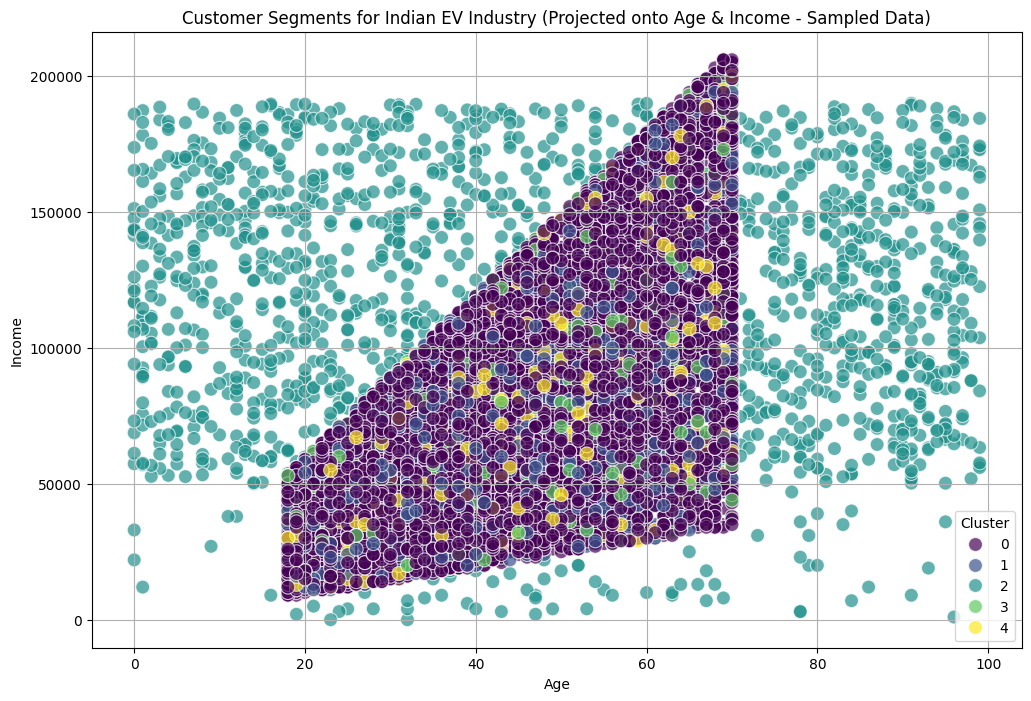


---Strategic Recommendations---
1. Target Age 30–60 & Income ₹6–15L with affordable EV models, financing options, and city-oriented features.
2. Focus Metro Cities like Bangalore, Pune, and Delhi with campaigns aimed at urban professionals and families.
3. Build Charging Infrastructure & Partner with Employers to enhance convenience and boost EV adoption.

--- Strategic Market Entry Considerations based on Enhanced Segmentation (Sampled Data) ---
1. Efficiency for Prototyping: This sampled analysis allows for quicker iteration and testing of segmentation strategies.
2. Targeted Product Development: Design EV models that align with the average income and family size of the most promising clusters. E.g., bigger family EVs for those with larger family sizes in high-income clusters.
3. Localized Marketing: Tailor marketing messages based on dominant professions (e.g., highlighting tech-savvy features for engineers) and city-specific characteristics (e.g., emphasizing charging infrastructu

Bad pipe message: %s [b'0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7\r\nHost: localhost:37851\r\nUs', b'-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/137.']
Bad pipe message: %s [b'0.0 Safari/537.36\r\nAccept-Encoding: gzip, defla']
Bad pipe message: %s [b', br, zstd\r\nAccept-Language: en-US,en;q=0.9\r\nCache-Control: max-age=0\r\nReferer: https://github.com/\r\nX-Request-ID: ', b'f462fac096c90f7a6c829ddbc5a161\r\nX-Real-IP: 152.']
Bad pipe message: %s [b'.12.201\r\nX-Forwarded-Port: 443\r\nX-Forwarded-Scheme: ']
Bad pipe message: %s [b'tps\r\nX-Original-URI: /\r\nX-Scheme: https\r\nsec-fetch-site: cross-site\r\nsec-fetch-mode: navigate\r\nsec-fetc']
Bad pipe message: %s [b'dest: document\r\nsec-ch-ua: "Google Chrome";v="137", "Chromium";v="137", "Not/A)Brand";v="24"\r\nsec-ch-ua', b'obile: ?0\r\nsec-ch-ua-platform: "Windows"\r\npr', b'rity: u=0, i\r\nX-Original-Proto: https\r\nX-Forwarded-Proto

In [ ]:
# To make interpretation easier, let's focus on the unscaled original features and dominant categories
final_clusters_df = combined_df_encoded.copy()
# Bring back original unscaled columns for easier interpretation of means/modes
# These come from the 'combined_df' BEFORE encoding, so we need to ensure alignment.
# Note: This re-creation assumes `combined_df` (before encoding) has the same index as `combined_df_encoded`.
# If indices diverge after concatenation or dropping rows, this step needs careful handling.
# Since we used `reset_index(drop=True)` after sampling and `ignore_index=True` for concat, indices should align.
final_clusters_df['Age_Original'] = combined_df['Age'].values
final_clusters_df['Income_Original'] = combined_df['Income'].values
final_clusters_df['Family_Size_Original'] = combined_df['Family Size'].values
final_clusters_df['Profession_Original'] = combined_df['Profession'].values
final_clusters_df['City_Original'] = combined_df['City'].values
final_clusters_df['Employment_Profile_Original'] = combined_df['Employment Profile'].values

print("\n📌 Enhanced Target Segment Recommendation for Indian EV Industry (Based on Sampled Data):\\")
for cluster_id in sorted(final_clusters_df['Cluster'].unique()):
    cluster_data = final_clusters_df[final_clusters_df['Cluster'] == cluster_id]
    print(f"\n--- Cluster {cluster_id} ---")
    print(f"  • Count: {len(cluster_data)} customers")
    print(f"  • Average Age: {cluster_data['Age_Original'].mean():.1f} years")
    print(f"  • Average Income: ₹{cluster_data['Income_Original'].mean():,.0f}")
    print(f"  • Average Family Size: {cluster_data['Family_Size_Original'].mean():.1f}")

    # Dominant Profession
    dominant_profession = cluster_data['Profession_Original'].mode()[0] if not cluster_data['Profession_Original'].mode().empty else 'N/A'
    print(f"  • Dominant Profession: {dominant_profession}")

    # Dominant City
    dominant_city = cluster_data['City_Original'].mode()[0] if not cluster_data['City_Original'].mode().empty else 'N/A'
    print(f"  • Dominant City: {dominant_city}")

    # Dominant Employment Profile
    dominant_employment = cluster_data['Employment_Profile_Original'].mode()[0] if not cluster_data['Employment_Profile_Original'].mode().empty else 'N/A'
    print(f"  • Dominant Employment Profile: {dominant_employment}")

    # Add qualitative interpretation based on averages/modes
    sampled_combined_df_income_mean = combined_df['Income'].mean() # This 'combined_df' is already sampled/processed here
    if cluster_data['Income_Original'].mean() > sampled_combined_df_income_mean and cluster_data['Age_Original'].mean() >= 30 and cluster_data['Age_Original'].mean() <= 60:
        print("  *This cluster represents a strong potential target for early EV adoption due to high income and suitable age.*")
    elif cluster_data['Income_Original'].mean() > sampled_combined_df_income_mean:
        print("  *This cluster has high income, making them potential EV buyers, but age group needs further consideration.*")
    else:
        print("  *This cluster might be a secondary target, requiring more affordable EV options or strong incentives.*")

print("\n--- Visualizing Clusters (2D Projection of High-Dimensional Data) ---")
print("Due to the high dimensionality, a direct scatter plot of all features is not feasible. We can visualize based on Age and Income as primary drivers, recognizing the clusters are formed using more data. This plot uses the sampled data.")

plt.figure(figsize=(12, 8))
sns.scatterplot(x='Age_Original', y='Income_Original', hue='Cluster', data=final_clusters_df, palette='viridis', s=100, alpha=0.7)
plt.title('Customer Segments for Indian EV Industry (Projected onto Age & Income - Sampled Data)')
plt.xlabel('Age')
plt.ylabel('Income')
plt.legend(title='Cluster')
plt.grid(True)
plt.savefig('Images/indian_ev_segments_scatter_enhanced_sampled.png')
plt.show()



print("\n---Strategic Recommendations---")
print("1. Target Age 30–60 & Income ₹6–15L with affordable EV models, financing options, and city-oriented features.")
print("2. Focus Metro Cities like Bangalore, Pune, and Delhi with campaigns aimed at urban professionals and families.")
print("3. Build Charging Infrastructure & Partner with Employers to enhance convenience and boost EV adoption.")

print("\n--- Strategic Market Entry Considerations based on Enhanced Segmentation (Sampled Data) ---")
print("1. Efficiency for Prototyping: This sampled analysis allows for quicker iteration and testing of segmentation strategies.")
print("2. Targeted Product Development: Design EV models that align with the average income and family size of the most promising clusters. E.g., bigger family EVs for those with larger family sizes in high-income clusters.")
print("3. Localized Marketing: Tailor marketing messages based on dominant professions (e.g., highlighting tech-savvy features for engineers) and city-specific characteristics (e.g., emphasizing charging infrastructure in tech hubs).")
print("4. Partnerships: Explore partnerships with employers or professional organizations dominant in target clusters for corporate sales or exclusive offers.")
print("5. Geographic Focus: Prioritize initial market entry in cities where highly desirable clusters are most prevalent, considering existing EV infrastructure and state incentives in those regions (requires external research).")
print("6. Validation: Remember that conclusions drawn from sampled data should ideally be validated on the full dataset if resources permit for final deployment. The insights gained here provide a strong basis for further, more exhaustive analysis.")
